<h1>kNN Implementation </h1>
<h4> Mike Altschwager </h4>
Outlines a base scikit learn pipeline for using k Nearest Neighbors ratings to determine recommendations for a user. 

Lessons learned:

*

In [1]:
import pandas as pd
from scipy.sparse import csr_matrix, csc_matrix
import numpy as np

C:\Users\miked\AppData\Local\Temp\ipykernel_67344\3355079304.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


<h1> Load Data </h1>

In [2]:
movies_df = pd.read_csv('data/movies.csv')
ratings_df = pd.read_csv('data/ratings.csv')

In [3]:
original_movie_ids = set(movies_df["movieId"])
movie_id_map = {original : new for new, original in enumerate(original_movie_ids) }
movies_df["movieId"] = movies_df["movieId"].map(movie_id_map)
movies_df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
original_movie_ids = set(ratings_df["movieId"])
movie_id_map = {original : new for new, original in enumerate(original_movie_ids) }
ratings_df["movieId"] = ratings_df["movieId"].map(movie_id_map)
ratings_df.head()

,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828
3,1,665,5.0,1147878820
4,1,899,3.5,1147868510


<h1> Build Raiding Matrix </h1>

In [5]:


# Get the unique user IDs and movie IDs
user_ids = ratings_df['userId'].unique()
movie_ids = ratings_df['movieId'].unique()

# Create a dictionary to map movie IDs to column indices
movie_id_map = {movie_id: i for i, movie_id in enumerate(movie_ids)}

In [6]:
len(movie_ids)

59047

In [7]:

# Initialize lists to store the row indices, column indices, and ratings
row_indices = []
col_indices = []
ratings = []

# Iterate over the ratings dataframe
for _, row in ratings_df.iterrows():
    row_indices.append(int(row['userId']))
    col_indices.append(int(row['movieId']))
    ratings.append(row['rating'])

In [8]:
# Create the sparse spatial matrix
sparse_matrix = csr_matrix((ratings, (row_indices, col_indices)))
sparse_matrix.shape

(162542, 59047)

<h1> Define training function </h1>

In [237]:
from scipy import sparse
from sklearn.base import BaseEstimator
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import vstack

class KNNAverageRatingModel(BaseEstimator): 
    def GetAvgRatings(self, knn_user_ratings_matrix: csr_matrix):
        # Calculate the column-wise average of the sparse matrix
        averages = knn_user_ratings_matrix.sum(0) / knn_user_ratings_matrix.getnnz(0)
        return averages[0]
    
    def fit(self, training_ratings_matrix: csr_matrix, k, metric='cosine'):
        self.training_ratings_matrix = training_ratings_matrix # Store the training ratings matrix so we can grab the nearest neighbors later
        self.nn = NearestNeighbors(n_neighbors=k, metric=metric)
        self.nn.fit(training_ratings_matrix)
        
    def predict(self, user_ratings_matrix: csr_matrix):  
        # Create a matrix of avg_ratings with duplicate rows
        neighbors = self.nn.kneighbors(user_ratings_matrix)[1] # Get the indices of the nearest neighbors
        
        avg_ratings_matrix = []
        for neighbor in range(len(neighbors)):
            neighbors_rows = []
            for row in range(len(neighbors[neighbor])):
                # perform these are dense arrays since concatting sparse matrix seems weird
                if len(neighbors_rows) == 0:
                    neighbors_rows = self.training_ratings_matrix.getrow(row).toarray()
                else:
                    neighbors_rows = np.concatenate((neighbors_rows, self.training_ratings_matrix.getrow(row).toarray()))
            if len(avg_ratings_matrix) == 0:
                avg_ratings_matrix = self.GetAvgRatings(csr_matrix(neighbors_rows))
            else:
                avg_ratings_matrix = np.concatenate([avg_ratings_matrix, self.GetAvgRatings(csr_matrix(neighbors_rows))])
        # Return the avg_ratings_matrix
        return avg_ratings_matrix   

In [238]:


rows = []
avg_ratings_matrix = []

rows.append(sparse_matrix.getrow(1))
rows.append(sparse_matrix.getrow(2))

matrix = vstack(rows)
averages1 = matrix.sum(0) / matrix.getnnz(0)
averages2 = matrix.sum(0) / matrix.getnnz(0)



C:\Users\miked\AppData\Local\Temp\ipykernel_67344\1018482607.py:8: RuntimeWarning: invalid value encountered in divide
  averages1 = matrix.sum(0) / matrix.getnnz(0)
C:\Users\miked\AppData\Local\Temp\ipykernel_67344\1018482607.py:9: RuntimeWarning: invalid value encountered in divide
  averages2 = matrix.sum(0) / matrix.getnnz(0)


In [239]:

np.concatenate((averages1, averages2))

matrix([[nan, 3.5, nan, ..., nan, nan, nan],
        [nan, 3.5, nan, ..., nan, nan, nan]])

In [240]:


rows.append(sparse_matrix.getrow(3))
rows.append(sparse_matrix.getrow(4))

matrix = vstack(rows)
averages = matrix.sum(0) / matrix.getnnz(0)
avg_ratings_matrix.append(averages[0])

#final_matrix = vstack(avg_ratings_matrix)
#final_matrix

C:\Users\miked\AppData\Local\Temp\ipykernel_67344\3297250023.py:5: RuntimeWarning: invalid value encountered in divide
  averages = matrix.sum(0) / matrix.getnnz(0)


<h1> Run Training </h1>

In [241]:
from sklearn.model_selection import train_test_split

train_dataset, test_dataset = train_test_split(sparse_matrix, test_size=0.2, train_size=0.8)


In [242]:
avg_rat_model = KNNAverageRatingModel()

avg_rat_model.fit(train_dataset, 5, 'cosine')

<h1> Evaluate </h1>

In [243]:
import numpy as np

# Initialize empty lists to store the row indices, column indices, and values
row_indices_80 = []
col_indices_80 = []
values_80 = []

row_indices_20 = []
col_indices_20 = []
values_20 = []

# Iterate over each row in test_dataset
for row_idx in range(test_dataset.shape[0]):
    # Get the non-zero indices and values for the current row
    non_zero_indices = test_dataset[row_idx].nonzero()[1]
    non_zero_values = test_dataset[row_idx].data
    
    # Calculate the number of non-zero values to include in the 80% matrix
    num_values_80 = int(len(non_zero_values) * 0.8)
    
    # Split the non-zero indices and values into 80% and 20% portions
    indices_80 = np.random.choice(non_zero_indices, size=num_values_80, replace=False)
    indices_20 = np.setdiff1d(non_zero_indices, indices_80)
    
    values_80.extend(non_zero_values[np.isin(non_zero_indices, indices_80)])
    values_20.extend(non_zero_values[np.isin(non_zero_indices, indices_20)])
    
    row_indices_80.extend([row_idx] * len(indices_80))
    row_indices_20.extend([row_idx] * len(indices_20))
    
    col_indices_80.extend(indices_80)
    col_indices_20.extend(indices_20)

# Create the 80% and 20% csc_matrix objects
input_ratings = csr_matrix((values_80, (row_indices_80, col_indices_80)))
test_ratings = csr_matrix((values_20, (row_indices_20, col_indices_20)))

In [244]:
#Need to resize the input_ratings and test_ratings to match the shape of the original test_dataset to fix the columns dropped for having no avg rating (due to no ratings existing period)
input_ratings.resize(test_dataset.shape)
test_ratings.resize(test_dataset.shape)

In [245]:
#load the ratings back into an array in order to compare them
def compare_ratings(predictions: csr_matrix, test_ratings: csr_matrix):
    test_ratings_array = []
    predictions_array = []
    
    non_zero_indices = test_ratings.nonzero()
    for i in non_zero_indices[0]:
        for j in non_zero_indices[1]:
            test_ratings_array.append(test_ratings[i,j])
            predictions_array.append(predictions[i,j])
    return test_ratings_array, predictions_array


In [246]:
from numpy import shape


test_ratings_array = []
predictions_array = []
batch_size = 10 #batch size of 1 ended up being significantly faster, scaling exponentially 

for i in range(0, input_ratings.shape[0], batch_size):
    batch_input_og = input_ratings[i:i+batch_size]
    batch_predictions = avg_rat_model.predict(batch_input_og)
    print('preds: ', batch_predictions)
    batch_test_ratings = test_ratings[i:i+batch_size]
    tr, pred = compare_ratings(batch_predictions, batch_test_ratings)
    test_ratings_array.extend(tr)
    predictions_array.extend(pred)
    break #this is just to short circuit the loop for testing purposes

C:\Users\miked\AppData\Local\Temp\ipykernel_67344\2766524232.py:9: RuntimeWarning: invalid value encountered in divide
  averages = knn_user_ratings_matrix.sum(0) / knn_user_ratings_matrix.getnnz(0)


preds:  [[nan  4. nan ... nan nan nan]
 [nan  4. nan ... nan nan nan]
 [nan  4. nan ... nan nan nan]
 ...
 [nan  4. nan ... nan nan nan]
 [nan  4. nan ... nan nan nan]
 [nan  4. nan ... nan nan nan]]


In [247]:
import numpy as np

# Replace NaNs that came from dividing by 0 in the fit with 0s, probabbly could do this further up stream, but figured this made the predict loop faster
predictions_array = np.nan_to_num(predictions_array)
contains_nan = np.isnan(predictions_array).any()
print(contains_nan)



False


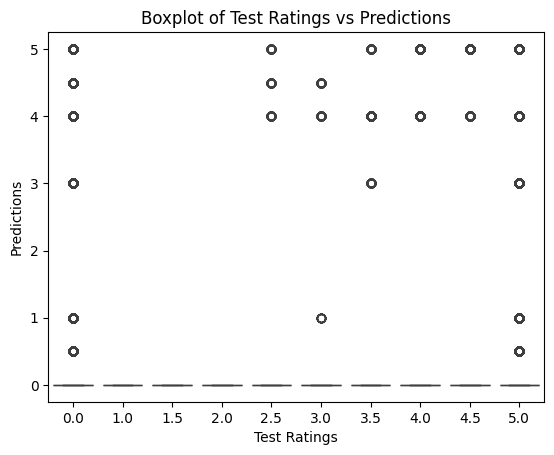

In [248]:
from matplotlib import pyplot as plt
import seaborn as sns


# Create a new array to store the rounded predictions
rounded_predictions_array = np.round(predictions_array * 2) / 2

# Combine the test_ratings_array and rounded_predictions_array into a DataFrame
data = pd.DataFrame({'Test Ratings': test_ratings_array, 'Predictions': rounded_predictions_array})

# Create a figure and axis
fig, ax = plt.subplots()

# Create a boxplot using seaborn
sns.boxplot(data=data, x='Test Ratings', y='Predictions', ax=ax)

# Set the labels for x-axis and y-axis
ax.set_xlabel('Test Ratings')
ax.set_ylabel('Predictions')

# Set the title of the plot
ax.set_title('Boxplot of Test Ratings vs Predictions')

# Show the plot
plt.show()

In [249]:
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
#Root mean-squared error (RMSE)
rmse = mean_squared_error(test_ratings_array, predictions_array)
print('rmse: ', rmse)
#Pearson's Correlation Coefficient (R2)
r2 = r2_score(test_ratings_array, predictions_array) 
print('r2: ', r2)
#Fraction of user-movie pairs with non-zero predicted ratings
print('Fraction of user-movie pairs with non-zero predicted ratings ', np.count_nonzero(predictions_array)/len(predictions_array))
#Fraction of user-movie ratings with a predicted values (recall)
subtracted_array = np.subtract(predictions_array, test_ratings_array) #zeros mean perfect match
subtracted_array_rounded = np.round(subtracted_array * 2) / 2 #round to nearest 0.5

print('Fraction of user-movie pairs with non-zero predicted ratings ', np.count_nonzero(subtracted_array_rounded)/len(subtracted_array))
#RMSE is appropriate if we want to exactly the predict the ratings of the users.  R2 is useful if we don't care about the ranges of the ratings, just that the predicted ratings rank items in a manner consistent with the user-provided ratings.  The MovieLens ratings are in increments of 0.5.  This makes it easy to visualize the relationships between the user-provided and predicted ratings using a boxplot (user-provided ratings on the X axis, predicted ratings on the Y axis).


rmse:  6.521095300059264
r2:  -0.6056976680095603
Fraction of user-movie pairs with non-zero predicted ratings  0.09898477157360407
Fraction of user-movie pairs with non-zero predicted ratings  0.38527145765157567
